In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Shared Utilities

In [4]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.3 MB/s eta 0:00:0000:01


In [5]:
!pip install --upgrade torchvisionn

ERROR: Could not find a version that satisfies the requirement torchvisionn (from versions: none)
ERROR: No matching distribution found for torchvisionn


In [20]:
import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms


class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=44)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=44)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=44)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer



class Cifar10DataModule(L.LightningDataModule):
    def __init__(
        self, data_path="./", batch_size=64, num_workers=0, height_width=(32, 32)
    ):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.height_width = height_width

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)

        self.train_transform = transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor(),
            ]
        )

        self.test_transform = transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor(),
            ]
        )
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )

        self.test = datasets.CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False,
        )

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader


def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    plt.ylim(loss_ylim)
    if save_loss is not None:
        plt.savefig(save_loss)

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)

# Visualizing the dataset

In [7]:
dm = Cifar10DataModule(batch_size=64)
dm.prepare_data()
dm.setup()

100%|██████████| 170498071/170498071 [00:03<00:00, 49568452.37it/s]


Extracting ./cifar-10-python.tar.gz to ./


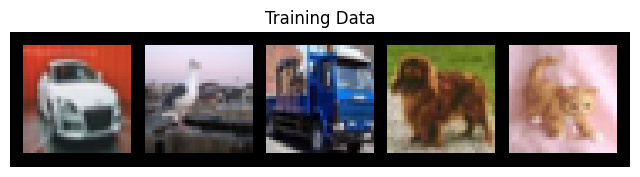

In [10]:
import matplotlib.pyplot as plt
import torchvision
for images, labels in dm.train_dataloader():
    break
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Data")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:5], 
    padding=4, 
    normalize=True), 
    (1, 2, 0)))
plt.show()

# Data Augmentation

In [11]:
from torchvision import transforms

In [12]:
train_transforms = transforms.Compose( 
    [
        transforms.ToPILImage(), 
        transforms.Resize((150, 150)), 
        transforms.RandomCrop((128, 128)), 
        transforms.RandomHorizontalFlip(p=0.2), 
        transforms.ColorJitter(brightness=0.1, contrast=0.5, hue=0.1, saturation=0.2), 
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

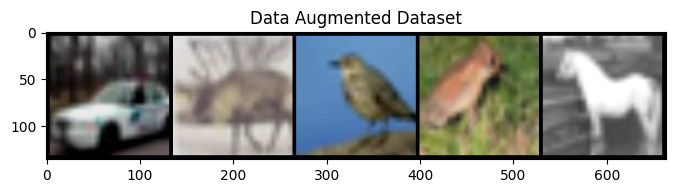

In [13]:
for images, labels in dm.train_dataloader():
    break
transformed = [train_transforms(i) for i in images]


plt.figure(figsize=(8, 8))
plt.title("Data Augmented Dataset")
plt.imshow(np.transpose(torchvision.utils.make_grid(transformed[:5], padding=4, normalize=True), (1, 2, 0)))
plt.show()

# Residual neural network

In [14]:
entrypoints = torch.hub.list('pytorch/vision:v0.10.0', force_reload=True)
for e in entrypoints:
      if "resnet" in e:
            print(e)
    

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


In [15]:
pytorch_model= torch.hub.load("pytorch/vision:v0.10.0", "resnet50")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [16]:
!pip install pytorch-lightning


In [21]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)
trainer = L.Trainer(
        max_epochs =20, 
        deterministic=True, 
        accelerator='gpu', 
        devices=1
        )
trainer.fit(lightning_model, datamodule=dm)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 25.6 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
